# Topology Optimized 90° Bend

We use topology optimization to design a compact, efficient 90° photonic waveguide bend from first principles using BEAMZ. The optimizer maximizes bidirectional transmission through the bend by iteratively updating the refractive index distribution within a defined design region, using the adjoint method with a material penalty to control core material usage.

**Author:** Quentin Wach
**Published:** 2025-10-4
**Updated:** 2026-02-12
**Tags:** Simulation, Optimization

![preview](attachment:imgs/topo_opt_bend.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from beamz import *
from beamz.optimization.topology import TopologyManager, compute_overlap_gradient, create_optimization_mask
from beamz.devices.sources.signals import plot_signal

# Hyperparameters
W = H = 7*µm
WG_W = 0.55*µm
WL = 1.55*µm
N_CORE, N_CLAD = 2.25, 1.444
DX, DT = calc_optimal_fdtd_params(WL, 2.25, points_per_wavelength=9)
STEPS = 40
MAT_PENALTY = 0.3      # Target core material fraction (0.0 to 1.0)
PENALTY_STRENGTH = 1   # Scaling factor for the penalty gradient

## Design

Our assumption is that we have slab waveguide structures and can therefore approximate the 3D structure using a 2D slice. Hence why we only have a `height` and `width` in our `Design()`. This allows us to simulate and optimize the domain extremely quickly.

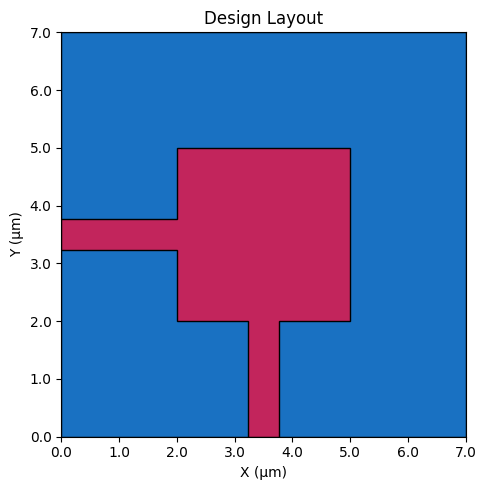

In [2]:
# Design & Materials
design = Design(width=W, height=H, material=Material(permittivity=N_CLAD**2))
design += Rectangle(position=(0, H/2-WG_W/2), width=W/2, height=WG_W, material=Material(permittivity=N_CORE**2))
design += Rectangle(position=(W/2-WG_W/2, 0), width=WG_W, height=H/2, material=Material(permittivity=N_CORE**2))

# Optimization Region (added as placeholder)
opt_region = Rectangle(position=(W/2-1.5*µm, H/2-1.5*µm), width=3*µm, height=3*µm, 
    material=Material(permittivity=N_CORE**2))
design += opt_region

design.show()

The square at the center of this 2D design will later be used to create the region within which we optimize the topology using the adjoint method.


## Sources
We need a mode source at the input on the left and one at the bottom for the forward and adjoint simulations respectively. We use TM polarization where the fields $E_z$, $H_x$, and $H_y$ are non-zero.

The `time` array defines every time step of our simulations. We use a ramped cosine signal which ramps up and down smoothly to avoid scattering artifacts.

● Auto-selecting 2D meshing for effectively 2D design (depth=0)

Output()

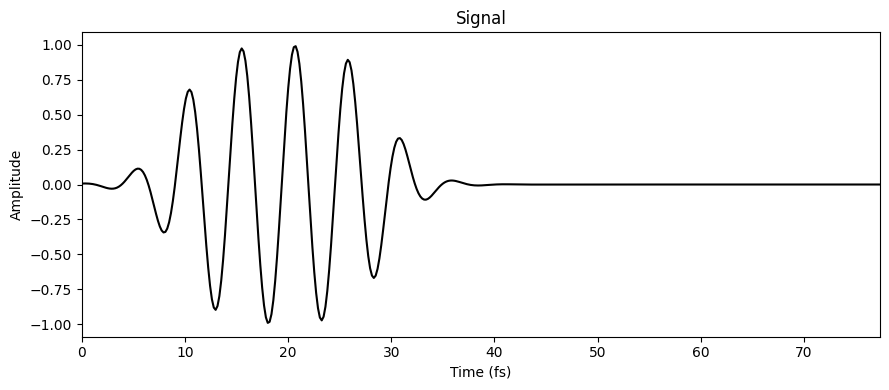

In [3]:
# Discretize the design
grid = design.rasterize(DX)

# Discrete time & signal
time = np.arange(0, 15*WL/LIGHT_SPEED, DT)
signal = ramped_cosine(time, 1, LIGHT_SPEED/WL, ramp_duration=3.5*WL/LIGHT_SPEED, t_max=time[-1]/2)
plot_signal(signal, time)

# Sources
src_fwd = ModeSource(None, center=(1.0*µm, H/2), width=WG_W*4, wavelength=WL, pol="tm", signal=signal, direction="+x")
src_adj = ModeSource(None, center=(W/2, 1.0*µm), width=WG_W*4, wavelength=WL, pol="tm", signal=signal, direction="+y")

## Topology Optimization

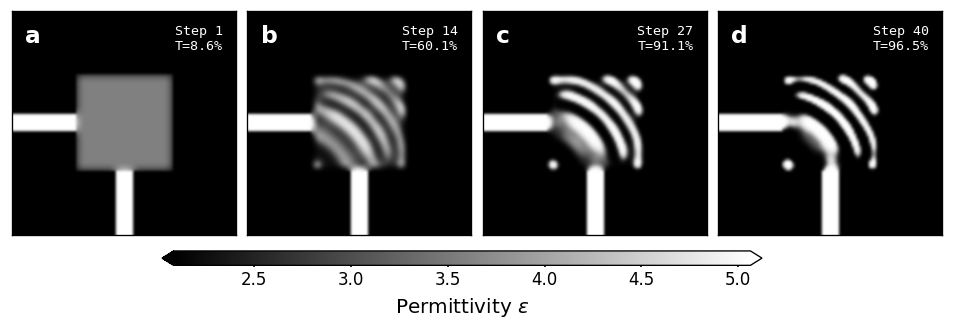

Optimization Complete. Final Transmission: 96.5%


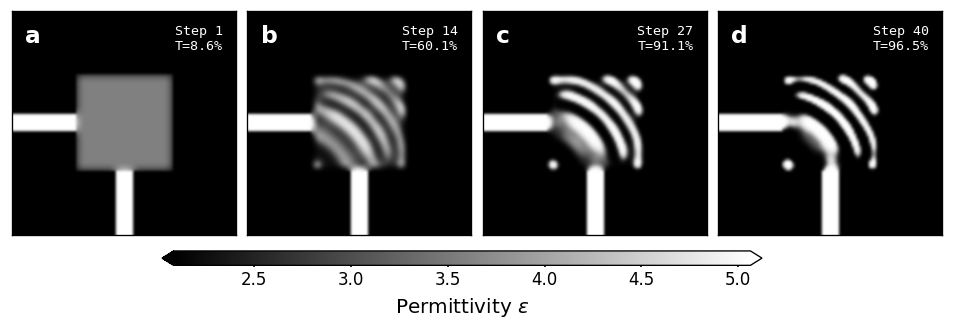

In [4]:
# Rasterize once to get grid and mask
mask = create_optimization_mask(grid, opt_region)

opt = TopologyManager(
    design=design,
    region_mask=mask,
    resolution=DX,
    learning_rate=0.015,
    filter_radius=0.3*µm,       # Physical units: Controls minimum feature size AND boundary smoothness
    eps_min=N_CLAD**2,
    eps_max=N_CORE**2,
    beta_schedule=(1.0, 20.0),
    filter_type="conic",         # Use conic filter for geometric constraints
)

print(f"Starting Topology Optimization ({STEPS} steps)...")
base_eps = grid.permittivity.copy() # Store background (cladding)

# Track transmission history
transmission_history = []

from IPython.display import display, clear_output

# 4 evenly-spaced snapshot steps
snapshot_steps = [int(i * (STEPS - 1) / 3) for i in range(4)]
labels = ['a', 'b', 'c', 'd']

fig_prog, axes_prog = plt.subplots(1, 4, figsize=(10, 3), squeeze=True, gridspec_kw={'wspace': 0.05}, dpi=120)
snapshot_ims = []
info_texts = []
for i, ax in enumerate(axes_prog):
    im = ax.imshow(np.full_like(grid.permittivity.T, N_CLAD**2, dtype=float),
                   cmap='gray', origin='lower', vmin=N_CLAD**2, vmax=N_CORE**2, interpolation='bicubic')
    ax.text(0.06, 0.94, labels[i], transform=ax.transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left', color='white')
    txt = ax.text(0.94, 0.94, '', transform=ax.transAxes,
                  fontsize=8, va='top', ha='right', color='white',
                  fontfamily='monospace')
    ax.set_xticks([])
    ax.set_yticks([])
    snapshot_ims.append(im)
    info_texts.append(txt)

# Single horizontal colorbar at bottom
cbar_ax = fig_prog.add_axes([0.25, 0.10, 0.5, 0.04])
cbar = fig_prog.colorbar(snapshot_ims[0], cax=cbar_ax, orientation='horizontal', extend='both', extendfrac=0.02)
cbar.set_label(r'Permittivity $\varepsilon$', fontsize=12, labelpad=4)
cbar.ax.tick_params(labelsize=10, length=1, width=1, pad=2)
display(fig_prog)

for step in range(STEPS):
    # Update Design
    beta, phys_density = opt.update_design(step, STEPS)
    
    # Mix Density into Permittivity (Linear Interpolation)
    grid.permittivity[:] = base_eps
    grid.permittivity[mask] = opt.eps_min + phys_density[mask] * (opt.eps_max - opt.eps_min)
    
    # Forward Simulation (only output monitor)
    src_fwd.grid = grid # Update grid ref
    
    # Setup monitors for input and output power measurement
    monitor_input_flux = Monitor(design=grid, start=(1.5*µm, H/2-WG_W*2), end=(1.5*µm, H/2+WG_W*2), 
                           accumulate_power=True, record_fields=False)
    output_monitor_fwd = Monitor(design=grid, start=(W/2-WG_W*2, 1.5*µm), end=(W/2+WG_W*2, 1.5*µm),
                                 accumulate_power=True, record_fields=False)
    
    # Run forward simulation with output monitor
    sim_fwd = Simulation(grid, [src_fwd, monitor_input_flux, output_monitor_fwd], 
                        [PML(edges='all', thickness=1*µm)], time=time, resolution=DX)
    
    print(f"[{step+1}/{STEPS}] Forward Sim...", end="\r")
    results = sim_fwd.run(save_fields=['Ez'], field_subsample=2)
    
    # Extract field history and ensure NumPy arrays
    fwd_ez_history = [np.array(field) for field in results['fields']['Ez']] if results and 'fields' in results else []
    
    # Calculate transmission normalizing by measured input flux
    measured_input_energy = np.sum(monitor_input_flux.power_history) * DT
    measured_output_energy = np.sum(output_monitor_fwd.power_history) * DT
    if measured_input_energy <= 0: measured_input_energy = 1.0
    transmission_fwd = (np.abs(measured_output_energy) / np.abs(measured_input_energy) * 100.0)
    
    # Backward Simulation (with backward monitor at input location)
    src_adj.grid = grid
    
    monitor_back_flux = Monitor(design=grid, start=(W/2-WG_W*2, 1.5*µm), end=(W/2+WG_W*2, 1.5*µm),
                              accumulate_power=True, record_fields=False)
    backward_monitor = Monitor(design=grid, start=(1.5*µm, H/2-WG_W*2), end=(1.5*µm, H/2+WG_W*2),
                              accumulate_power=True, record_fields=False)
    
    sim_adj = Simulation(grid, [src_adj, monitor_back_flux, backward_monitor], 
                        [PML(edges='all', thickness=1*µm)], time=time, resolution=DX)
    
    adj_results = sim_adj.run(save_fields=['Ez'], field_subsample=2)
    adj_ez_history = [np.array(field) for field in adj_results['fields']['Ez']] if adj_results and 'fields' in adj_results else []
    
    # Calculate backward transmission normalizing by measured backward input flux
    measured_input_energy_back = np.sum(monitor_back_flux.power_history) * DT
    if measured_input_energy_back <= 0: measured_input_energy_back = 1.0
    
    output_energy_back = np.sum(backward_monitor.power_history) * DT
    transmission_back = (np.abs(output_energy_back) / np.abs(measured_input_energy_back) * 100.0)
    
    # Average bidirectional transmission
    transmission_pct = (transmission_fwd + transmission_back) / 2.0
    obj_val = transmission_pct
    
    opt.objective_history.append(obj_val)
    transmission_history.append(transmission_pct)
            
    # Compute Gradient (overlap of fwd and adj fields)
    grad_eps = compute_overlap_gradient(fwd_ez_history, adj_ez_history)
    grad_eps = np.array(grad_eps)

    # Material penalty gradient
    current_density = np.mean(phys_density[mask])
    grad_penalty = PENALTY_STRENGTH * (current_density - MAT_PENALTY)
    grad_eps[mask] -= grad_penalty

    # Total Objective for display
    penalty_val = PENALTY_STRENGTH * 0.5 * (current_density - MAT_PENALTY)**2
    total_obj = obj_val - penalty_val
    
    # Step Optimizer
    max_update = opt.apply_gradient(grad_eps, beta)
    
    mat_frac = np.mean(phys_density[mask])
    
    print(f" Step {step+1}: Obj={total_obj:.2e} (Trans={transmission_pct:.1f}% | Fwd={transmission_fwd:.1f}% Bwd={transmission_back:.1f}%) | Mat={mat_frac:.1%} | MaxUp={max_update:.2e}", end="\r")
    
    # Viz: update 4-panel figure at snapshot steps
    if step in snapshot_steps:
        idx = snapshot_steps.index(step)
        snapshot_ims[idx].set_data(grid.permittivity.T)
        info_texts[idx].set_text(f'Step {step+1}\nT={transmission_pct:.1f}%')
        clear_output(wait=True)
        display(fig_prog)

print(f"Optimization Complete. Final Transmission: {transmission_history[-1]:.1f}%")

## Plotting the Results

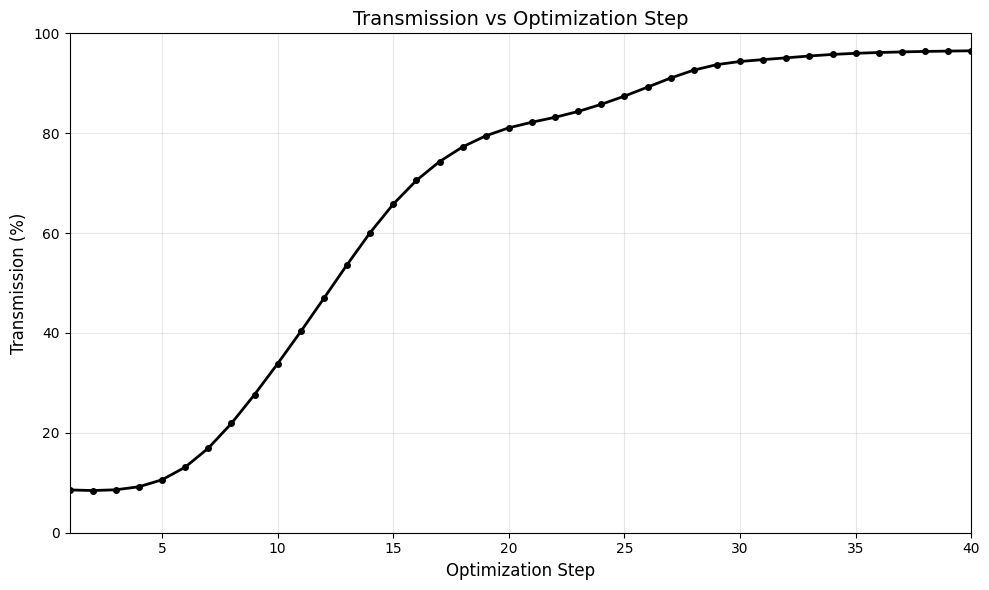

--- Running Broadband Pulse Simulation ---
Broadband simulation complete.


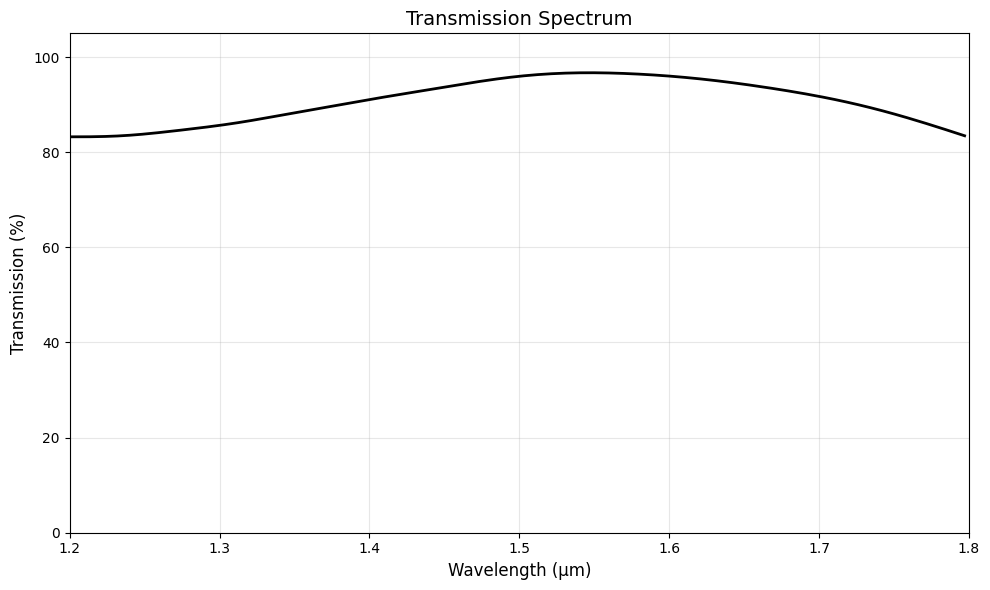

--- Generating Final Field Plot (1.55 µm) ---


NameError: name 'time_sweep' is not defined

In [5]:
# Plot transmission vs step (as percentage)
plt.figure(figsize=(10, 6))
steps = np.arange(1, len(transmission_history) + 1)
plt.plot(steps, transmission_history, 'o-', linewidth=2, markersize=4, color='black')
plt.xlabel('Optimization Step', fontsize=12)
plt.ylabel('Transmission (%)', fontsize=12)
plt.title('Transmission vs Optimization Step', fontsize=14)
plt.ylim(0, 100)
plt.xlim(1, 40)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Broadband Pulse + FFT for Transmission Spectrum ---
print("--- Running Broadband Pulse Simulation ---")

from beamz.devices.sources.signals import gaussian_pulse

WL_CENTER = 1.5*µm
time_broad = np.arange(0, 60*WL/LIGHT_SPEED, DT)
sig_broad = gaussian_pulse(time_broad, amplitude=1,
    center=5*WL/LIGHT_SPEED, width=1.0*WL/LIGHT_SPEED,
    frequency=LIGHT_SPEED/WL_CENTER, phase=0)

src_broad = ModeSource(grid, center=(1.0*µm, H/2), width=WG_W*4,
                       wavelength=WL_CENTER, pol="tm", signal=sig_broad, direction="+x")
mon_in_broad = Monitor(design=grid, start=(1.5*µm, H/2-WG_W*2), end=(1.5*µm, H/2+WG_W*2),
                       record_fields=True, accumulate_power=False, record_interval=1)
mon_out_broad = Monitor(design=grid, start=(W/2-WG_W*2, 1.5*µm), end=(W/2+WG_W*2, 1.5*µm),
                        record_fields=True, accumulate_power=False, record_interval=1)
sim_broad = Simulation(grid, [src_broad, mon_in_broad, mon_out_broad],
                       [PML(edges='all', thickness=1*µm)], time=time_broad, resolution=DX)
sim_broad.run(save_fields=[], field_subsample=10)

# FFT the recorded fields to get transmission spectrum
Ez_in  = np.array(mon_in_broad.fields['Ez'])   # (Nt, Ny)
Hx_in  = np.array(mon_in_broad.fields['Hx'])   # (Nt, Ny)
Ez_out = np.array(mon_out_broad.fields['Ez'])   # (Nt, Nx)
Hy_out = np.array(mon_out_broad.fields['Hy'])   # (Nt, Nx)

# Zero-pad for smooth spectral interpolation
Nt = len(Ez_in)
n_fft = 8 * Nt

Ez_in_f  = np.fft.rfft(Ez_in, n=n_fft, axis=0)
Hx_in_f  = np.fft.rfft(Hx_in, n=n_fft, axis=0)
Ez_out_f = np.fft.rfft(Ez_out, n=n_fft, axis=0)
Hy_out_f = np.fft.rfft(Hy_out, n=n_fft, axis=0)
freqs = np.fft.rfftfreq(n_fft, DT)

# Half-step correction for E-H time staggering in FDTD leapfrog
phase_corr = np.exp(-1j * np.pi * freqs * DT)[:, np.newaxis]

# Spectral Poynting flux (beamz swaps Hx/Hy labels vs standard convention)
# Input: vertical monitor, Sx = Ez·Hx_beamz
P_in_f  = np.real(np.sum(Ez_in_f * np.conj(Hx_in_f) * phase_corr, axis=1))
# Output: horizontal monitor, Sy = Ez·Hy_beamz
P_out_f = np.real(np.sum(Ez_out_f * np.conj(Hy_out_f) * phase_corr, axis=1))

T_f = P_out_f / np.where(P_in_f > 0, P_in_f, 1.0)

wl_f = LIGHT_SPEED / np.where(freqs > 0, freqs, np.inf)
mask_wl = (wl_f >= 1.2*µm) & (wl_f <= 1.8*µm)
wl_plot = wl_f[mask_wl]
T_plot = T_f[mask_wl] * 100

sort_idx = np.argsort(wl_plot)
wl_plot, T_plot = wl_plot[sort_idx], T_plot[sort_idx]

print("Broadband simulation complete.")

# Plot Transmission Spectrum
plt.figure(figsize=(10, 6))
plt.plot(wl_plot/µm, T_plot, '-', linewidth=2, color='black')
plt.xlabel('Wavelength (µm)', fontsize=12)
plt.ylabel('Transmission (%)', fontsize=12)
plt.title('Transmission Spectrum', fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim(0, 105)
plt.xlim(1.2, 1.8)
plt.tight_layout()
plt.show()

# --- Final Visualization (Center Wavelength) ---
print("--- Generating Final Field Plot (1.55 µm) ---")
signal_final = ramped_cosine(time, 1, LIGHT_SPEED/WL, ramp_duration=3.5*WL/LIGHT_SPEED, t_max=time[-1]/2)
src_final = ModeSource(grid, center=(1.0*µm, H/2), width=WG_W*4, wavelength=WL, pol="tm", signal=signal_final, direction="+x")
src_final.initialize(grid.permittivity, DX)

mon_in_final = Monitor(design=grid, start=(1.5*µm, H/2-WG_W*2), end=(1.5*µm, H/2+WG_W*2), accumulate_power=True)
mon_out_final = Monitor(design=grid, start=(W/2-WG_W*2, 1.5*µm), end=(W/2+WG_W*2, 1.5*µm), accumulate_power=True)

sim_final = Simulation(grid, [src_final, mon_in_final, mon_out_final], [PML(edges='all', thickness=1*µm)], time=time_sweep, resolution=DX)
results_final = sim_final.run(save_fields=['Ez', 'Hx', 'Hy'], field_subsample=1)

# Calculate final transmission
in_E = np.sum(mon_in_final.power_history) * DT
out_E = np.sum(mon_out_final.power_history) * DT
trans_final = (np.abs(out_E) / np.abs(in_E) * 100.0) if np.abs(in_E) > 0 else 0.0

print("Calculating energy flow...")
Ez_t = np.array(results_final['fields']['Ez'])
Hx_t = np.array(results_final['fields']['Hx'])
Hy_t = np.array(results_final['fields']['Hy'])

min_x = min(Ez_t.shape[1], Hx_t.shape[1], Hy_t.shape[1])
min_y = min(Ez_t.shape[2], Hx_t.shape[2], Hy_t.shape[2])

Ez_c = Ez_t[:, :min_x, :min_y]
Hx_c = Hx_t[:, :min_x, :min_y]
Hy_c = Hy_t[:, :min_x, :min_y]

Sx_t = -Ez_c * Hy_c
Sy_t = Ez_c * Hx_c
S_mag_t = np.sqrt(Sx_t**2 + Sy_t**2)
energy_flow = np.sum(S_mag_t, axis=0) * DT

plt.figure(figsize=(10, 8))
perm_c = grid.permittivity[:min_x, :min_y]
plt.imshow(perm_c.T, cmap='gray', origin='lower', alpha=0.2)
plt.contour(perm_c.T, levels=[(N_CORE**2 + N_CLAD**2)/2], colors='white', linewidths=0.5, origin='lower')
im = plt.imshow(energy_flow.T, cmap='inferno', origin='lower', alpha=0.9, interpolation='bicubic')
plt.colorbar(im, label=r'Time-Integrated Energy Flow $\int |\mathbf{S}| dt$')
plt.title(f'Final Energy Flow Map (1.55 µm)')
plt.xlabel('x (grid cells)')
plt.ylabel('y (grid cells)')
#plt.xlim(1, 40)
plt.tight_layout()
plt.show()